## Import Libraries

In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import radon.complexity as cc
import radon.metrics as mi
import matplotlib.pyplot as plt

## Configuration

In [2]:
DATASET_DIR = "../Rust_Dataset"
IMG_SIZE = 640
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 0.001
NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda


## Data Loading

In [3]:
def get_dataloaders():
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_DIR, x), data_transforms[x])
                      for x in ['train', 'valid', 'test']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
                   for x in ['train', 'valid']}
    test_loader = DataLoader(image_datasets['test'], batch_size=1, shuffle=False)
    return dataloaders, test_loader

dataloaders, test_loader = get_dataloaders()
print("Data loaders created successfully")

Data loaders created successfully


## Model Setup

In [4]:
# Build Model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

# V2 Head: classifier[1] is the Linear layer
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
model = model.to(DEVICE)

optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(f"MobileNetV2 model loaded and configured")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

MobileNetV2 model loaded and configured
Total parameters: 2,228,996


## Training

In [5]:
print(f"--- Training MobileNetV2 (Baseline) on {DEVICE} ---")

# Track metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_running_loss / val_total
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")

print("Training completed!")

--- Training MobileNetV2 (Baseline) on cuda ---
Epoch 1/15 - Train Acc: 0.5068, Val Acc: 0.6992
Epoch 1/15 - Train Acc: 0.5068, Val Acc: 0.6992
Epoch 2/15 - Train Acc: 0.6804, Val Acc: 0.6992
Epoch 2/15 - Train Acc: 0.6804, Val Acc: 0.6992
Epoch 3/15 - Train Acc: 0.7306, Val Acc: 0.6748
Epoch 3/15 - Train Acc: 0.7306, Val Acc: 0.6748
Epoch 4/15 - Train Acc: 0.7192, Val Acc: 0.7317
Epoch 4/15 - Train Acc: 0.7192, Val Acc: 0.7317
Epoch 5/15 - Train Acc: 0.7283, Val Acc: 0.7724
Epoch 5/15 - Train Acc: 0.7283, Val Acc: 0.7724
Epoch 6/15 - Train Acc: 0.7489, Val Acc: 0.7480
Epoch 6/15 - Train Acc: 0.7489, Val Acc: 0.7480
Epoch 7/15 - Train Acc: 0.7306, Val Acc: 0.7642
Epoch 7/15 - Train Acc: 0.7306, Val Acc: 0.7642
Epoch 8/15 - Train Acc: 0.7717, Val Acc: 0.7398
Epoch 8/15 - Train Acc: 0.7717, Val Acc: 0.7398
Epoch 9/15 - Train Acc: 0.7694, Val Acc: 0.7073
Epoch 9/15 - Train Acc: 0.7694, Val Acc: 0.7073
Epoch 10/15 - Train Acc: 0.7900, Val Acc: 0.7724
Epoch 10/15 - Train Acc: 0.7900, Val Ac

## Training Curves

## Evaluation & Metrics

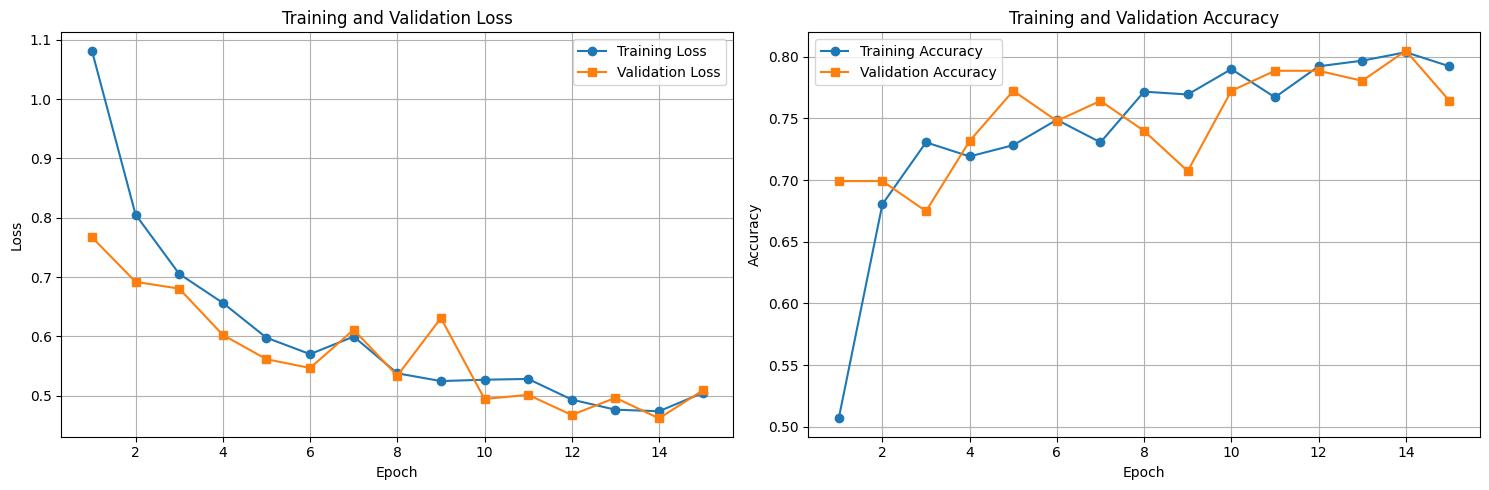

In [6]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(range(1, EPOCHS+1), train_losses, label='Training Loss', marker='o')
ax1.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(range(1, EPOCHS+1), train_accuracies, label='Training Accuracy', marker='o')
ax2.plot(range(1, EPOCHS+1), val_accuracies, label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [7]:
print("\n--- Results for MobileNetV2 ---")

# 1. Manufacturability
total_params = sum(p.numel() for p in model.parameters())

# 2. Efficiency
model.eval()
start_time = time.time()
all_probs = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.numpy())
end_time = time.time()
inf_time = ((end_time - start_time) / len(test_loader.dataset)) * 1000

# 3. Performance
y_true = np.concatenate(all_labels)
y_scores = np.concatenate(all_probs)
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
map_score = average_precision_score(y_true_bin, y_scores, average='macro')

# 4 & 5. Code Metrics
try:
    with open('mobilenet_v2.py', 'r') as f: code = f.read()
    cc_score = np.mean([i.complexity for i in cc.cc_visit(code)])
    mi_score = mi.mi_visit(code, multi=False)
except: cc_score, mi_score = 0, 0

print(f"1. Manufacturability (Params):      {total_params:,}")
print(f"2. Efficiency (Inference Time):     {inf_time:.2f} ms/image")
print(f"3. Performance (mAP):               {map_score:.4f}")
print(f"4. Functionality (Cyclomatic Cplx): {cc_score:.2f}")
print(f"5. Compatibility (Maint. Index):    {mi_score:.2f}")


--- Results for MobileNetV2 ---
1. Manufacturability (Params):      2,228,996
2. Efficiency (Inference Time):     9.38 ms/image
3. Performance (mAP):               0.9450
4. Functionality (Cyclomatic Cplx): 5.50
5. Compatibility (Maint. Index):    56.96
1. Manufacturability (Params):      2,228,996
2. Efficiency (Inference Time):     9.38 ms/image
3. Performance (mAP):               0.9450
4. Functionality (Cyclomatic Cplx): 5.50
5. Compatibility (Maint. Index):    56.96


## Save Model

In [8]:
torch.save(model.state_dict(), 'rust_mobilenetv2.pth')
print("Model saved to rust_mobilenetv2.pth")

Model saved to rust_mobilenetv2.pth
